# Import libraries

Use conda env with tensorflow-gpu and keras

In [6]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import seaborn as sns
import numpy as np
import geojson
import dask
import os

from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import backend as K

import cv2
import glob
import json
import numpy as np
import rasterio
from keras.applications.vgg16 import VGG16
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

from datetime import datetime
from gbdxtools.task import env
from gbdxtools import CatalogImage
from functools import partial
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skimage import filters

# Instantiating an Interface object automatically logs you in to the GBDX platform
from gbdxtools import Interface
gbdx = Interface()

Using TensorFlow backend.


# Get prebuild training dataset

In [7]:
path = '../../TreeTect/data/trainings_data_waterbodies/data_non_acomp_all_polygons_2020-03-21 12:54:09.945770.csv'

nr_search = path.split('/')[-1].split('_')[4]

nr_search


# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv(path).drop('Unnamed: 0', axis = 1).drop(['x','y'], axis= 1)

# First we rename the columns of our dataset 

# Bands
# coastal = data[0]
# blue = data[1]
# green = data[2]
# yellow = data[3]
# red = data[4]
# red_edge = data[5]
# nir1 = data[6]
# nir2 = data[7]

    # select variables
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names  + ['label']

# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)

data_raw['wwi'] = (data_raw.coastal-data_raw.nir2)/(data_raw.coastal+data_raw.nir2+10e-5)

data_clean = data_raw


all_variables = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names + ['ndvi','ndwi', 'wwi']

i = 0 
for variable in all_variables:
    print(i, variable)
    i = i + 1
    
variable_selection = range(17)

all_variables = [all_variables[i] for i in variable_selection]

data = data_clean[all_variables].values

# Normalize training data to between 0 and 1
try:
    min_data =  np.nanmin(data)
    max_data = np.nanmax(data)
    data = (data - min_data) / (max_data - min_data)
except Exception as e:
    print(e)

0 coastal
1 blue
2 green
3 yellow
4 red
5 red_edge
6 nir1
7 nir2
8 cloudCover
9 multiResolution
10 targetAzimuth
11 sunAzimuth
12 offNadirAngle
13 sunElevation
14 panResolution
15 ndvi
16 ndwi
17 wwi


In [8]:
data_clean

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,cloudCover,multiResolution,targetAzimuth,sunAzimuth,offNadirAngle,sunElevation,panResolution,label,ndvi,ndwi,wwi
0,1008.0,877.0,764.0,564.0,510.0,324.0,328.0,188.0,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.217184,0.399267,0.685619
1,1088.0,834.0,625.0,469.0,388.0,262.0,202.0,117.0,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.315254,0.511487,0.805809
2,1326.0,1141.0,992.0,788.0,692.0,411.0,359.0,224.0,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.316841,0.468542,0.710968
3,1278.0,1111.0,953.0,710.0,634.0,361.0,328.0,181.0,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.318087,0.487900,0.751885
4,1306.0,1118.0,955.0,730.0,627.0,358.0,297.0,187.0,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.357143,0.525559,0.749498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269399,1468.0,1191.0,1085.0,850.0,710.0,1748.0,2779.0,2119.0,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,0.593007,-0.438406,-0.181489
269400,1519.0,1237.0,1121.0,874.0,741.0,1827.0,3206.0,2534.0,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,0.624525,-0.481858,-0.250432
269401,1759.0,1529.0,1303.0,1153.0,1161.0,986.0,1065.0,804.0,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,-0.043127,0.100507,0.372610
269402,2136.0,2039.0,1910.0,1861.0,1901.0,1673.0,1760.0,1343.0,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,-0.038514,0.040872,0.227939


In [9]:
X = data 

# Similarly, we can extract the labels
y = data_clean['label'].values == 'water'

X.shape


(269404, 17)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0, shuffle=True, stratify=labels)

# First split the data samples into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('')
print('Training Data Shape: ', X_train.shape)   # Convert to 2-D tensor -> X_train[nb_samples, nb_channels]
print('Training Data Dtype: ', X_train.dtype)
print('Training Labels Shape: ', y_train.shape) # Convert to 1-D tensor -> y_train[nb_samples]
print('Training Labels Dtype: ', y_train.dtype)

# Second, split the the validation data into validation and testing sets
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.33, random_state=42, stratify=y_validation)

print('')
print('Validation Data Shape: ',X_validation.shape)  # Convert to 2-D tensor -> X_validation[nb_samples, nb_channels]
print('Validation Data Shape: ', X_validation.dtype)
print('Validation Labels: ', y_validation.shape)     # Convert to 1-D tensor -> y_validation[nb_samples]
print('Validation Labels: ', y_validation.dtype)

print('')
print('Test Data Shape: ',X_test.shape)  # Convert to 2-D tensor -> testData[nb_samples, nb_channels]
print('Test Data Shape: ', X_test.dtype)
print('Test Labels: ', y_test.shape)     # Convert to 1-D tensor -> testLabels[nb_samples]
print('Test Labels: ', y_test.dtype)


Training Data Shape:  (188582, 17)
Training Data Dtype:  float64
Training Labels Shape:  (188582,)
Training Labels Dtype:  bool

Validation Data Shape:  (54150, 17)
Validation Data Shape:  float64
Validation Labels:  (54150,)
Validation Labels:  bool

Test Data Shape:  (26672, 17)
Test Data Shape:  float64
Test Labels:  (26672,)
Test Labels:  bool


In [11]:
np.savez_compressed('../../TreeTect/data/bfalg_data/train.npz',
                    X_train=X_train,
                    y_train=y_train)
np.savez_compressed('../../TreeTect/data/bfalg_data/validation.npz',
                    X_validation=X_validation,
                    y_validation=y_validation)
np.savez_compressed('../../TreeTect/data/bfalg_data/test.npz',
                    X_test=X_test,
                    y_test=y_test)
np.savez_compressed('../../TreeTect/data/bfalg_data/minMax.npz',
                    min_data=min_data,
                    max_data=max_data)

### Define the Deep Learning Model.

The model is a shallow multi-layer perceptron (MLP), using only fully-connnected (Dense) layers. We also use dropout layers and ReLu activation. The reason why we used drop-out layers is that we found the model's predictive capability to be less prone to false-alarm on 'blue-topped' buildings or other man-made structures.

In [12]:
# Define the Multi-layer Perceptron (MLP) neural network model
def create_baseline(dimensions):
    # Create model
    model = Sequential()
    model.add(Dense(dimensions, input_dim=dimensions, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(2, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    opt = Adam(decay=0.000005)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Display the model summary
    model.summary()

    # Return the newly constructed network architecture
    return model

### Create custom callback to terminate early

This custom Keras callback will terminate early if either the minimal learning rate has been achieved (i.e., plateaus) or the maximum number of Epochs has been reached.

In [13]:
# Create custom callback to terminate early if minimum learning rate 
# has been achieved or the maximum number of Epochs has been reached
class EarlyStoppingByLearningRate(Callback):
    def __init__(self, min_lr=0., max_epochs=100, verbose=0):
        super(Callback, self).__init__()
        self.min_lr = min_lr
        self.max_epochs = max_epochs
        self.verbose = verbose
        self.init_lr=0
        self.curr_lr=0
        self.decay=0
        self.iterations=0

    def on_epoch_end(self, epoch, logs={}):
        self.init_lr = K.get_value(self.model.optimizer.lr)
        self.decay = K.get_value(self.model.optimizer.decay)
        self.iterations = K.get_value(self.model.optimizer.iterations)
        self.curr_lr = self.init_lr * (1. / (1. + self.decay * self.iterations))

        if self.curr_lr < self.min_lr or epoch == self.max_epochs:
            if self.verbose > 0:
                print("The current LR = {0:10.8f} at Epoch = {1:05d}".format(self.curr_lr, epoch))
            self.model.stop_training = True

In [14]:
# Specify the list of training 'batch' sizes
batch_sizes = [200] # [200, 300, 400, 500] # [100]
n_samples, dimensions= X.shape

for (cnt, batch_size) in enumerate(batch_sizes):

    print("Training the water-land classes predictive model ...")

    # Load our MLP binary classifier model
    model = create_baseline(dimensions) # create_baseline2(800, 800, transfer_learning = True, l_r = 0.0001)

    # Specify the minimum learning rate, the maximum number of epochs, and the batch size
    min_learning_rate = 0.000001
    max_epochs = 200

    # Use reduce learning rate if validation loss plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=2, factor=0.1, patience=25, min_lr=min_learning_rate)

    # Use checkpointer callback to save the model everytime the validation accuracy increases
    weights = '../../TreeTect/data/bfalg_models/bfalg_' + 'batchSize_' + str(batch_size) + '_Epoch-{epoch:05d}-Val_acc-{accuracy:.5f}_' + 'weights.hdf5'
    checkpointer = ModelCheckpoint(weights, monitor='accuracy', verbose=2, save_best_only=True, mode='max')

    # Early stopping by learning rate callback
    earlyStop = EarlyStoppingByLearningRate(min_lr=min_learning_rate, max_epochs=max_epochs, verbose=2)

    # Create list of all of the callbacks
    callbacks_list = [reduce_lr, checkpointer, earlyStop]
    
    history = model.fit(X_train, 
                        y_train,
                        batch_size=batch_size,
                        epochs=max_epochs, 
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=(X_validation, y_validation))
    
    # Evaluate and display the accuracy using the test data
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

    # Output the loss and accuracy on the held-out testing set
    print()
    print("Test loss: {:.4f}%".format(loss))
    print("Test accuracy: {:.4f}%".format(accuracy * 100))
    
    # List all data in history
    print(history.history.keys())

Training the water-land classes predictive model ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 17)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
Train on 188582 samples, validate on 54150 samples
Epoch 1/200
188582

188582/188582 [==============================] - 5s 24us/step - loss: 0.1468 - accuracy: 0.9423 - val_loss: 0.1290 - val_accuracy: 0.9515

Epoch 00023: accuracy improved from 0.94147 to 0.94233, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00023-Val_acc-0.94233_weights.hdf5
Epoch 24/200
188582/188582 [==============================] - 4s 22us/step - loss: 0.1453 - accuracy: 0.9431 - val_loss: 0.1240 - val_accuracy: 0.9569

Epoch 00024: accuracy improved from 0.94233 to 0.94309, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00024-Val_acc-0.94309_weights.hdf5
Epoch 25/200
188582/188582 [==============================] - 4s 23us/step - loss: 0.1438 - accuracy: 0.9438 - val_loss: 0.1259 - val_accuracy: 0.9555

Epoch 00025: accuracy improved from 0.94309 to 0.94378, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00025-Val_acc-0.94378_weights.hdf5
Epoch 26/200
188582/188582 [==============================]


Epoch 00051: accuracy did not improve from 0.94979
Epoch 52/200
188582/188582 [==============================] - 4s 21us/step - loss: 0.1260 - accuracy: 0.9498 - val_loss: 0.1034 - val_accuracy: 0.9605

Epoch 00052: accuracy did not improve from 0.94979
Epoch 53/200
188582/188582 [==============================] - 4s 23us/step - loss: 0.1261 - accuracy: 0.9498 - val_loss: 0.1085 - val_accuracy: 0.9582

Epoch 00053: accuracy did not improve from 0.94979
Epoch 54/200
188582/188582 [==============================] - 5s 26us/step - loss: 0.1260 - accuracy: 0.9497 - val_loss: 0.1051 - val_accuracy: 0.9597

Epoch 00054: accuracy did not improve from 0.94979
Epoch 55/200
188582/188582 [==============================] - 4s 21us/step - loss: 0.1264 - accuracy: 0.9494 - val_loss: 0.1112 - val_accuracy: 0.9576

Epoch 00055: accuracy did not improve from 0.94979
Epoch 56/200
188582/188582 [==============================] - 5s 25us/step - loss: 0.1251 - accuracy: 0.9500 - val_loss: 0.1029 - val_ac


Epoch 00084: accuracy did not improve from 0.95529
Epoch 85/200
188582/188582 [==============================] - 3s 18us/step - loss: 0.1194 - accuracy: 0.9539 - val_loss: 0.0986 - val_accuracy: 0.9601

Epoch 00085: accuracy did not improve from 0.95529
Epoch 86/200
188582/188582 [==============================] - 3s 18us/step - loss: 0.1192 - accuracy: 0.9548 - val_loss: 0.0988 - val_accuracy: 0.9600

Epoch 00086: accuracy did not improve from 0.95529
Epoch 87/200
188582/188582 [==============================] - 4s 20us/step - loss: 0.1181 - accuracy: 0.9555 - val_loss: 0.0963 - val_accuracy: 0.9606

Epoch 00087: accuracy improved from 0.95529 to 0.95550, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00087-Val_acc-0.95550_weights.hdf5
Epoch 88/200
188582/188582 [==============================] - 4s 21us/step - loss: 0.1192 - accuracy: 0.9544 - val_loss: 0.0986 - val_accuracy: 0.9596

Epoch 00088: accuracy did not improve from 0.95550
Epoch 89/200
188582/1

188582/188582 [==============================] - 4s 24us/step - loss: 0.1114 - accuracy: 0.9579 - val_loss: 0.0921 - val_accuracy: 0.9618

Epoch 00121: accuracy did not improve from 0.95836
Epoch 122/200
188582/188582 [==============================] - 3s 18us/step - loss: 0.1108 - accuracy: 0.9579 - val_loss: 0.0938 - val_accuracy: 0.9608

Epoch 00122: accuracy did not improve from 0.95836
Epoch 123/200
188582/188582 [==============================] - 3s 18us/step - loss: 0.1127 - accuracy: 0.9573 - val_loss: 0.0922 - val_accuracy: 0.9616

Epoch 00123: accuracy did not improve from 0.95836
Epoch 124/200
188582/188582 [==============================] - 7s 35us/step - loss: 0.1115 - accuracy: 0.9577 - val_loss: 0.0919 - val_accuracy: 0.9613

Epoch 00124: accuracy did not improve from 0.95836
Epoch 125/200
188582/188582 [==============================] - 6s 31us/step - loss: 0.1117 - accuracy: 0.9579 - val_loss: 0.0935 - val_accuracy: 0.9608

Epoch 00125: accuracy did not improve from 0.


Epoch 00159: accuracy did not improve from 0.95858
Epoch 160/200
188582/188582 [==============================] - 5s 26us/step - loss: 0.1098 - accuracy: 0.9583 - val_loss: 0.0911 - val_accuracy: 0.9627

Epoch 00160: accuracy did not improve from 0.95858
Epoch 161/200
188582/188582 [==============================] - 4s 20us/step - loss: 0.1107 - accuracy: 0.9586 - val_loss: 0.0909 - val_accuracy: 0.9627

Epoch 00161: accuracy improved from 0.95858 to 0.95860, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00161-Val_acc-0.95860_weights.hdf5
Epoch 162/200
188582/188582 [==============================] - 5s 24us/step - loss: 0.1103 - accuracy: 0.9587 - val_loss: 0.0925 - val_accuracy: 0.9620

Epoch 00162: accuracy improved from 0.95860 to 0.95871, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00162-Val_acc-0.95871_weights.hdf5
Epoch 163/200
188582/188582 [==============================] - 4s 20us/step - loss: 0.1109 - accuracy: 0.9

188582/188582 [==============================] - 4s 23us/step - loss: 0.1105 - accuracy: 0.9583 - val_loss: 0.0915 - val_accuracy: 0.9621

Epoch 00199: accuracy did not improve from 0.95871
Epoch 200/200
188582/188582 [==============================] - 4s 19us/step - loss: 0.1104 - accuracy: 0.9586 - val_loss: 0.0909 - val_accuracy: 0.9622

Epoch 00200: accuracy did not improve from 0.95871

Test loss: 0.0916%
Test accuracy: 96.2545%
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


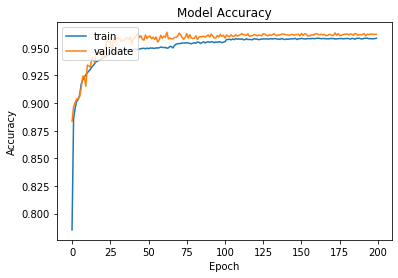

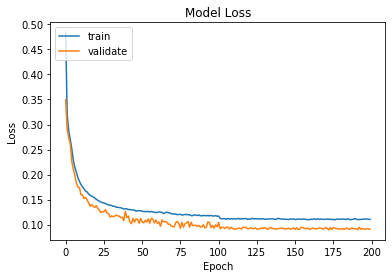

In [15]:
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)    

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)

In [16]:
y_pred = model.predict(X_test)

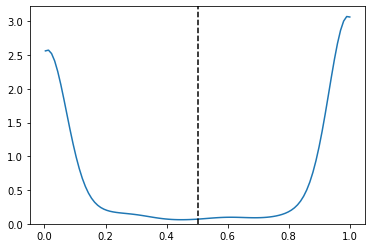

In [17]:
sns.kdeplot(y_pred.flatten(),cut=0);
thresh = filters.threshold_otsu(y_pred)
plt.axvline(thresh, color='k', ls='--');
plt.draw()
plt.show()


In [18]:
print('Otsu Threshold:', thresh)
print('Precision Score:', precision_score(y_test, y_pred>thresh))
print('Recall Score:', recall_score(y_test, y_pred>thresh))
print('F1-Score:', f1_score(y_test, y_pred>thresh))

Otsu Threshold: 0.503488
Precision Score: 0.975038348905313
Recall Score: 0.9559094948390184
F1-Score: 0.965379172275724


# Do inference

In [3]:
# load model
from keras.models import load_model

path = '../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00170-Val_acc-0.96432_weights.hdf5'
model = load_model(path)

In [19]:
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd

from gbdxtools import Interface
gbdx = Interface()

In [20]:
def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    if rgb.mean() > 1:
        rgb[rgb > 255] = 255
    else: 
        rgb[rgb > 1] = 1
    
    return rgb

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

## Get data from GBDX

In [45]:
# get setu babakan data and write to geotiff

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '104001004CBD1F00')
bbox = env.inputs.get('bbox', '106.82, -6.354, 106.824, -6.347')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), pansharpen = True)


import datetime

name = 'Setu_mangga_bolong'

image_id = catalog_id

# Get timestamp
time_image = image.metadata["image"]["acquisitionDate"] 

# convert timestamp to datetime timestamp format
time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")
    
time_image_str = time_image.strftime('%Y-%m-%d_%H:%M')

path = "../../TreeTect/data/rasters_waterbodies_osm/{}_{}_{}.tif".format(name,time_image_str,image_id)

path

tif = image.geotiff(
    path = path
                 )

KeyboardInterrupt: 

In [ ]:
path

## Use raster file

In [46]:
# find files in shapefile folder
raster_files_path = '../../TreeTect/data/rasters_waterbodies_osm/Setu_m*.tif'
raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files[0:5])
print('-------------------------------------')
print(file_path)

1
-------------------------------------
['../../TreeTect/data/rasters_waterbodies_osm/Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif']
-------------------------------------
../../TreeTect/data/rasters_waterbodies_osm/Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif


3545718/3545718 [==============================] - 138s 39us/step


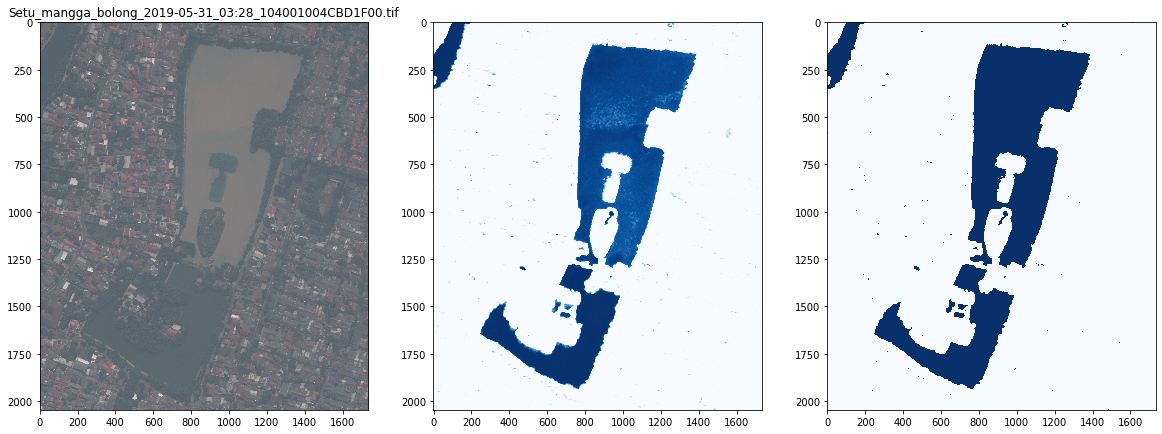

saved as:  ../../TreeTect/data/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif


In [47]:

for file_path in np.array(pd.DataFrame(raster_files).sample(1)).flatten(): 
    
    filename = file_path.split('/')[-1]

    import rasterio

    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)

    transform = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    # Split image data into band layers
    blocksize = 1

    coastal = data[0] # threshold_local(data[0], blocksize, offset=0) 
    blue    = data[1] # threshold_local(data[1], blocksize, offset=0) 
    green   = data[2] # threshold_local(data[2], blocksize, offset=0) 
    yellow  = data[3] # threshold_local(data[3], blocksize, offset=0)
    red     = data[4] # threshold_local(data[4], blocksize, offset=0) 
    red_edge = data[5] # threshold_local(data[5], blocksize, offset=0) 
    nir1 = data[6] # threshold_local(data[6], blocksize, offset=0)
    nir2 = data[7] # threshold_local(data[7], blocksize, offset=0) 

    # get info from filenames
    stringlist = file_path.split('/')[-1].split('_')
    image_id = stringlist[-1].split('.')[0]

    record = gbdx.catalog.get(image_id)

    i = 8

    for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]  

                property_array = np.empty([1,data.shape[1],data.shape[2]])
                property_array.fill(property_record)

                data = np.vstack([data,property_array])
            except: 
                print('failed ', property_name, image_id)
                property_array = np.empty([1,data.shape[1],data.shape[2]])
                data = np.vstack([data,property_array])

            i = i + 1


    # Calculate indices
    # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
    ndvi = reshape((nir1 - red)/(nir1 + red))
    ndwi = reshape((green - nir1) / (green + nir1))
    wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

    # Stack arrays in sequence vertically (row wise)
    image_array = np.vstack([data,ndvi,ndwi, wwi])

    # variable_selection = range(17)

    image_array = image_array[variable_selection,:,:]

    # image_array = data

    image_array.shape

    ### Reshape the data prior to feeding it through the model.

    # Flatten the two-dimensional imagery (i.e., Reshape)
    d2, h2, w2 = image_array.shape
    data_pred = np.reshape(image_array,(d2,h2*w2)).T

    # Convert data type to 32-bit float, and normalize between 0 and 1
    data_pred.astype(np.float32)
    data_pred = (data_pred - min_data) / (max_data - min_data)

    # Next, conduct model prediction on each spectral column
    labels_pred = model.predict(data_pred, verbose = 1, workers = 4)
    labels_pred = np.reshape(labels_pred,(h2,w2))

    ### Plot the predictions and the derived threshold.

    
    thresh = filters.threshold_otsu(labels_pred)
#     sns.kdeplot(labels_pred.flatten(),cut=0);
#     plt.axvline(thresh, color='k', ls='--');
#     plt.draw()
#     plt.show()

    ### Plot the input image alongside its corresponding predictions.

    plt.figure(figsize=(20,20))
    plt.subplot(131);plt.imshow(rgb_from_raster(data, 0.0)); plt.title(filename)
    plt.subplot(132);plt.imshow(labels_pred, cmap = 'Blues');
    plt.subplot(133);plt.imshow(labels_pred > 0.4, cmap = 'Blues');
    plt.draw()
    plt.show()
    
    # save classifications
    array_classification = labels_pred > thresh
    array_classification = array_classification.astype(float)
    
    classification_filename = '../../TreeTect/data/raster_classifications/classification_' + filename

    with rasterio.open(
        classification_filename,
        'w',
        driver='GTiff',
        height=array_classification.shape[0],
        width=array_classification.shape[1],
        count=1,
        dtype=array_classification.dtype,
        crs='+proj=latlong',
        transform=transform,
    ) as dst:
        dst.write(array_classification, 1)
        
        
    print('saved as: ', classification_filename)

In [48]:
with rasterio.open(
    classification_filename,
    'w',
    driver='GTiff',
    height=array_classification.shape[0],
    width=array_classification.shape[1],
    count=1,
    dtype=array_classification.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(array_classification, 1)


print('saved as: ', classification_filename)

saved as:  ../../TreeTect/data/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif


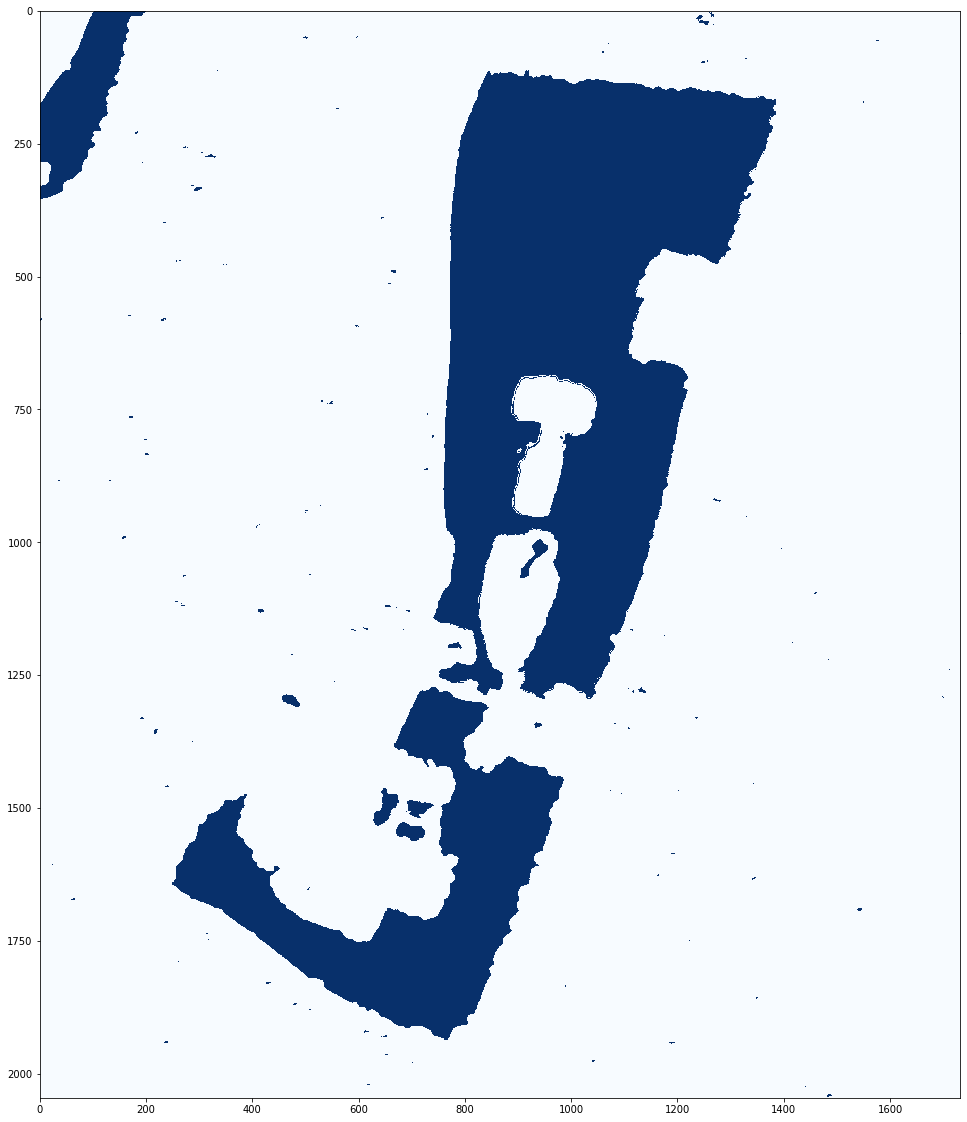

In [49]:
plt.figure(figsize = (20,20))
plt.imshow(labels_pred > thresh, cmap = 'Blues')